In [22]:
from typing import List
import torch
from torch import nn

class mCSI(nn.Module):
    """Compute the critical success index (CSI) score."""
    def __init__(self, thresholds: List[float] = [ 16., 74., 133. ], eps: float = 1e-4) -> None:
        super().__init__()
        self.thresholds = thresholds
        self.eps = eps
    
    @staticmethod
    def _threshold(y_true: torch.FloatTensor, y_pred: torch.FloatTensor, threshold: float) -> torch.FloatTensor:
        """Apply a threshold to both the target and the prediction tensors.

        Parameters
        ----------
        y_true : FloatTensor
            The target tensor.
        y_pred : FloatTensor
            The prediction tensor.
        threshold : float
            The threshold to apply.

        Returns
        -------
        FloatTensor
            The thresholded target tensor.
        FloatTensor
            The thresholded prediction tensor.
        """
    
        y_true_res = (y_true >= threshold).float()
        y_pred_res = (y_pred >= threshold).float()

        is_nan = torch.isnan(y_true) | torch.isnan(y_pred)

        y_true_res[is_nan] = 0
        y_pred_res[is_nan] = 0

        return y_true_res, y_pred_res

    def forward(self, pred, target):
        """
        Compute the critical success index (CSI) score.
         
        Parameters
        ----------
        pred, target:   torch.Tensor
            shape = (batch_size, seq_len, height, width)
        """
        results = 0.

        with torch.no_grad():
            for thresh in self.thresholds:
                target, pred = self._threshold(target, pred, thresh)
                hits = torch.sum(target * pred, dim=(-3)).int()
                misses = torch.sum(target * (1 - pred), dim=(-3)).int()
                fas = torch.sum((1 - target) * pred, dim=(-3)).int()
                csi = hits / (hits + misses + fas + self.eps)
                results += csi.mean()

        return results / len(self.thresholds)

In [23]:
import wandb
wandb.login(key='d3d31786e16c5dffe9ee01690d0bb069cac55e84', relogin=True, force=True)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\riccardo/.netrc


True

In [24]:
from pathlib import Path

def ls(path: Path): 
    "Return files on Path, sorted"
    return sorted(list(path.iterdir()))

In [25]:
from pathlib import Path

import numpy as np
import torch
import torchvision.transforms as T
import wandb
from tqdm import tqdm as progress_bar
import cv2

# from cloud_diffusion.utils import ls

PROJECT_NAME = "cloud_diffusion"
DATASET_ARTIFACT = 'ai-industry/cloud_diffusion/SEVIR:v0'

class DummyNextFrameDataset:
    "Dataset that returns random images"
    def __init__(self, num_frames=4, img_size=64, N=1000):
        self.img_size = img_size
        self.num_frames = num_frames
        self.N = N

    def __getitem__(self, idx):
        return torch.randn(self.num_frames, self.img_size, self.img_size)
    
    def __len__(self):
        return self.N


class CloudDataset:
    """Dataset for cloud images
    It loads numpy files from wandb artifact and stacks them into a single array
    It also applies some transformations to the images
    """
    def __init__(self, 
                 files, # list of numpy files to load (they come from the artifact)
                 num_frames=4, # how many consecutive frames to stack
                 scale=True, # if we images to interval [-0.5, 0.5]
                 img_size=64, # resize dim, original images are big (446, 780)
                 valid=False, # if True, transforms are deterministic
                ):
        #self.means=[]
        #self.stds=[]
        #tfms = [T.Normalize(self.means, self.stds)]
        tfms = [T.RandomCrop(img_size)] if not valid else [T.CenterCrop(img_size)]
        self.tfms = T.Compose(tfms)
        self.load_data(files, num_frames, scale)

        
    def _scale(self, arr):
        "Scales values of array in [0,1]"
        m, M = arr.min(), arr.max()
        return (arr - m) / (M - m)

    def _calculate_mean_std(self, arr):
        "Calculate mean and std for normalization"
        mean, std = arr.mean(), arr.std()
        self.means.append(mean)
        self.stds.append(std)

    def _resize(self, arr, img_size):
        num_events, num_frames = arr.shape[0], arr.shape[3]
        resized_array = np.empty((num_events, img_size, img_size, num_frames))
        for event in range(num_events):
            resized_array[event] = cv2.resize(arr[event], (img_size, img_size))
        return resized_array.transpose((0, 3, 1, 2))
    
    def load_channel(self, file, scale=True):
        one_channel = np.load(file)
        one_channel = one_channel.astype('float32')
        if scale:
            one_channel = 0.5 - self._scale(one_channel)
            # self._calculate_mean_std(one_channel)
        return one_channel

    def create_windows(self, data, num_frames):
        windows = []
        for event in data:
            wds = np.lib.stride_tricks.sliding_window_view(
                        event,
                        num_frames,
                        axis=0)[::num_frames].transpose(0,4,1,2,3) # (windows, frames, channels, height, width)
            windows.append(wds)
        windows = np.array(windows)
        shape = windows.shape
        windows = windows.reshape(shape[0] * shape[1], shape[2], shape[3], shape[4], shape[5])
        windows = windows.astype('float32')
        return windows # (batch, channels, frames, height, width)

    def load_data(self, files, num_frames, scale, img_size=64):
        "Loads all data into a single array self.data"
        channels = []
        # Load all channels
        for file in progress_bar(files, leave=False):
            one_channel = self.load_channel(file, scale)
            resized_array = self._resize(one_channel, img_size)
            channels.append(resized_array)
            del one_channel
        all_channels = np.stack(channels, axis=2)
        self.data = self.create_windows(all_channels, num_frames)

    def shuffle(self):
        """Shuffles the dataset, useful for getting 
        interesting samples on the validation dataset"""
        idxs = torch.randperm(len(self.data))
        self.data = self.data[idxs]
        return self

    @staticmethod
    def _scale(arr):
        "Scales values of array in [0,1]"
        m, M = arr.min(), arr.max()
        return (arr - m) / (M - m)
    
    def __getitem__(self, idx):
        return self.tfms(torch.from_numpy(self.data[idx]))
    
    def __len__(self): return len(self.data)

    def save(self, fname="cloud_frames.npy"):
        np.save(fname, self.data)


class CloudDatasetInference(CloudDataset):
     def load_data(self, files, num_frames=None, scale=None):
        "Loads all data into a single array self.data"
        data = []
        max_length = 100
        # TODO: download everything
        for file in files:
            one_day = self.load_day(file, scale)
            data.append(one_day)
            max_length = min(max_length, len(one_day))
        self.data = np.stack([d[:max_length] for d in data], axis=0).squeeze()


def download_dataset(at_name, project_name):
    "Downloads dataset from wandb artifact"
    def _get_dataset(run):
        artifact = run.use_artifact(at_name, type='dataset')
        return artifact.download()

    if wandb.run is not None:
        run = wandb.run
        artifact_dir = _get_dataset(run)
    else:
        run = wandb.init(project=project_name, job_type="download_dataset")
        artifact_dir = _get_dataset(run)
        run.finish()

    files = ls(Path(artifact_dir))
    return files

In [26]:
files = download_dataset(DATASET_ARTIFACT, project_name=PROJECT_NAME)
train_ds = CloudDataset(files)
print(f"Let's grab 5 samples: {train_ds[0:5].shape}")

wandb: Downloading large artifact SEVIR:v0, 2756.25MB. 3 files... Done. 0:0:0.0


Let's grab 5 samples: torch.Size([5, 4, 3, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


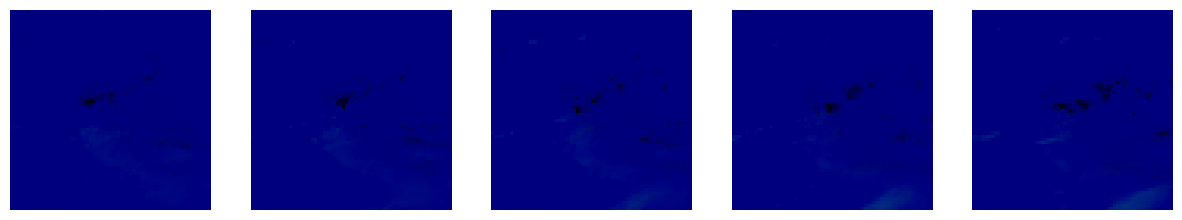

In [27]:
import matplotlib.pyplot as plt
# Show some samples
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axs):
    ax.imshow(train_ds[i][0].permute(1,2,0).numpy())
    ax.axis('off')

In [31]:
train_ds[0]

tensor([[[[-0.2151, -0.2228, -0.2280,  ..., -0.1831, -0.1855, -0.1891],
          [-0.2127, -0.2176, -0.2221,  ..., -0.1879, -0.1898, -0.1931],
          [-0.2093, -0.2151, -0.2211,  ..., -0.1925, -0.1982, -0.1929],
          ...,
          [-0.1805, -0.1874, -0.1945,  ..., -0.2013, -0.2061, -0.2021],
          [-0.1870, -0.1960, -0.1944,  ..., -0.2021, -0.2021, -0.2020],
          [-0.1912, -0.1920, -0.1937,  ..., -0.2045, -0.1990, -0.1980]],

         [[-0.1859, -0.1942, -0.1793,  ..., -0.2080, -0.2110, -0.2089],
          [-0.1806, -0.2001, -0.1886,  ..., -0.2100, -0.2099, -0.2103],
          [-0.1847, -0.1960, -0.1935,  ..., -0.2039, -0.2054, -0.2077],
          ...,
          [-0.1847, -0.1753, -0.1701,  ..., -0.0870, -0.1596, -0.0866],
          [-0.1831, -0.1772, -0.1801,  ..., -0.1125, -0.1214, -0.1356],
          [-0.1720, -0.1763, -0.1937,  ..., -0.1697, -0.0809, -0.1123]],

         [[ 0.5000,  0.5000,  0.5000,  ...,  0.5000,  0.5000,  0.5000],
          [ 0.5000,  0.5000,  

In [48]:
m_csi = mCSI(thresholds=[.02])

m_csi(train_ds[0], train_ds[0])

tensor(0.9998)

In [42]:
train_ds[0:5].shape

torch.Size([5, 4, 3, 64, 64])